import package

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statsmodels.api as sm

read data

In [2]:
# read data
crypto_data = pd.read_csv('C:\\Users\\louis\\backtesting/100market_value.csv',index_col=False)

In [3]:
crypto_data

,Date,symbol,name,Close,Volume,Market_Cap,_TYPE_,date_1,symbol_1,name_1,close_1,return
0,2017-08-17,ZRX,0x,0.206735,2752410.00,1.240410e+08,0,2017-08-16,ZRX,0x,0.224399,-0.081988
1,2017-08-18,ZRX,0x,0.293387,12793800.00,1.760322e+08,0,2017-08-17,ZRX,0x,0.206735,0.350055
2,2017-08-19,ZRX,0x,0.478768,52677500.00,2.872608e+08,0,2017-08-18,ZRX,0x,0.293387,0.489724
3,2017-08-20,ZRX,0x,0.424265,16016500.00,2.545590e+08,0,2017-08-19,ZRX,0x,0.478768,-0.120858
4,2017-08-21,ZRX,0x,0.351503,15013800.00,1.757515e+08,0,2017-08-20,ZRX,0x,0.424265,-0.188140
...,...,...,...,...,...,...,...,...,...,...,...,...
205184,2022-10-28,RLC,iExec R,1.054500,12607458.31,9.174129e+07,0,2022-10-27,RLC,iExec R,1.069409,-0.014040
205185,2022-10-29,RLC,iExec R,1.074808,6886308.72,9.350803e+07,0,2022-10-28,RLC,iExec R,1.054500,0.019075
205186,2022-10-30,RLC,iExec R,1.057845,15978250.12,9.203227e+07,0,2022-10-29,RLC,iExec R,1.074808,-0.015908
205187,2022-10-31,RLC,iExec R,1.060792,7854831.59,9.228864e+07,0,2022-10-30,RLC,iExec R,1.057845,0.002782


function

In [151]:
# remove no volatility coin
def delete_USD(df):
    for i in range(len(df)):
        if df['symbol'][i]=='USD':
            df = df.drop(i)
    df = df.reset_index(drop=True)
    return df

# create dict dataset -> {'btc':price df, 'eth':price df .....}
def split_different_coin(df):
    diff_symbol_data = {}
    start_index = 0
    for i in range(1, len(df)):
        if df['symbol'][i-1]!=df['symbol'][i]:
            diff_symbol_data[df['symbol'][i-1]] = df.iloc[start_index:i].reset_index(drop=True)
            start_index = i
    diff_symbol_data[df['symbol'].iloc[-1]] = df.iloc[start_index:].reset_index(drop=True)
    return diff_symbol_data


def date_timestamp(df_dict):
    for df in df_dict.values():
        df['Date'] = pd.to_datetime(df['Date'])
        
def split_time_seq(df_dict, j_window_size = 90, k_window_size = 90):
    j_dataset = []
    k_dataset = []
    price_data = list(df_dict.values())
        
    for i in range(0, len(df_dict['BTC']), 30):
        try:
            j_start_date = df_dict['BTC']['Date'][i]
            j_end_date = df_dict['BTC']['Date'][i+j_window_size]
            k_start_date = df_dict['BTC']['Date'][i+j_window_size]
            k_end_date = df_dict['BTC']['Date'][i+k_window_size+j_window_size]
            j_window_data = {}
            k_window_data = {}
    
        except:
            break
                        
        for j in range(len(price_data)):
            try:
                j_start_index = price_data[j].index[price_data[j]['Date'] == j_start_date].to_list()[0]
                j_end_index = price_data[j].index[price_data[j]['Date'] == j_end_date].to_list()[0]
                j_window_data[price_data[j]['symbol'][0]] = price_data[j].iloc[j_start_index:j_end_index].reset_index(drop=True) 

                k_start_index = price_data[j].index[price_data[j]['Date'] == k_start_date].to_list()[0]
                k_end_index = price_data[j].index[price_data[j]['Date'] == k_end_date].to_list()[0]
                k_window_data[price_data[j]['symbol'][0]] = price_data[j].iloc[k_start_index:k_end_index].reset_index(drop=True)                    
            
            except:
                pass            
        j_dataset.append(j_window_data)
        k_dataset.append(k_window_data)    
        
    return j_dataset, k_dataset

def get_profolio(j_data):
    # j data lookback data
    # k data test data
    long_position = []
    short_position = []
    profolio_std = []
  
    for window_data in j_data:
        window_std = []
        long_profit = 0
        short_profit = 0
        if len(window_data)<=10:
            long_position.append([])
            short_position.append([])
            profolio_std.append(window_std)
            continue
        else:
            # calculate SD
            std = {}
            for symbol, price_data in window_data.items():
                volatility = price_data['return'].var()
                # remove extreme value
                #if volatility>0.25:
                #    continue
               #else:
                std[symbol] = volatility
            std_dict = dict(sorted(std.items(), key=lambda x: x[1], reverse=False))
            print(std_dict)
            # create profolio
            # top 10% long position / last 10% short position
            long_p = list(std_dict.keys())[:int(len(std_dict)*0.1)]
            short_p = list(std_dict.keys())[int(-len(std_dict)*0.1):]
            #long_p = list(std_dict.keys())[:10]
            #short_p = list(std_dict.keys())[-10:]
            print(long_p)
            print(short_p)
            print('---------------')
            long_position.append(long_p)
            short_position.append(short_p)
            
        
            for long in long_p:
                window_std.append(std[long])
            for short in short_p:
                window_std.append(std[short])
            
            profolio_std.append(window_std)
            
    return long_position,  short_position, profolio_std


def get_return(k_data, long_position, short_position):
    long_return = []
    short_return = []
    individual_return = []
    
    for price_data, long, short in zip(k_data, long_position, short_position):
        window_return = []
        long_profit = 0
        short_profit = 0
        if len(long) ==0:
            long_return.append(long_profit)
            short_return.append(short_profit)
            individual_return.append(window_return)
            continue
        else:
            print('long return')
            
            for long_symbol in long:
                try:
                    #long_profit+=((price_data[long_symbol]['Close'].iloc[-1]-price_data[long_symbol]['Close'].iloc[0])/price_data[long_symbol]['Close'].iloc[0])
                    long_profit+= sum(price_data[long_symbol]['return'])
                    #long_profit+= (np.exp(sum(price_data[long_symbol]['return']))-1)
                    print(f"{long_symbol} return {np.exp(sum(price_data[long_symbol]['return']))-1}")
                    window_return.append(sum(price_data[long_symbol]['return']))
                except:
                    window_return.append('error')
                    
            print('short')
            
            for short_symbol in short:
                try:
                    
                    #short_profit+= (np.exp(sum(price_data[short_symbol]['return']))-1)
                    short_profit+= sum(price_data[short_symbol]['return'])
                    window_return.append(sum(price_data[short_symbol]['return']))
                    print(f"{short_symbol} return {np.exp(sum(price_data[short_symbol]['return']))-1}")
                    #short_profit+=((price_data[short_symbol]['Close'].iloc[-1]-price_data[short_symbol]['Close'].iloc[0])/price_data[short_symbol]['Close'].iloc[0])
                
                except:
                    window_return.append('error')
            #
            #/(len(long_position)+len(short_position))
            
            #long_return.append(math.exp(long_profit/(len(long)+len(short)))-1)
            #short_return.append(math.exp(short_profit/(len(long)+len(short)))-1)
            print(long_profit)
            print(short_profit)
            #print(f'long profit : {long_profit}')
            #print(f'short_profit : {short_profit}')
            long_return.append(long_profit/(len(long)+len(short)))
            short_return.append(short_profit/(len(long)+len(short)))
            individual_return.append(window_return)
        print('-------------------------------------------------------')
    return long_return, short_return, individual_return

In [5]:
crypto_data = delete_USD(crypto_data)
diff_symbol = split_different_coin(crypto_data)
date_timestamp(diff_symbol)

In [152]:
j_dataset, k_dataset = split_time_seq(diff_symbol)

In [153]:
long_position,  short_position, profolio_std = get_profolio(j_dataset)

{'BTC': 0.0006788924543648443, 'LTC': 0.002801734646797091, 'DOG': 0.0037433553772200315, 'XRP': 0.0037826766221470635, 'MAI': 0.007304005117246263, 'DGB': 0.008959995435179302, 'XMR': 0.01558881707655716, 'DAS': 0.018834456000072657, 'XWC': 0.020976810043025144, 'GRS': 0.025562404543839887, 'MON': 0.04452420286545024}
['BTC']
['MON']
---------------
{'BTC': 0.0008745125361331585, 'XRP': 0.0013885445568565865, 'MAI': 0.002910955621960438, 'LTC': 0.0029617344350331984, 'XMR': 0.0038311839868673176, 'DGB': 0.00646160735636377, 'DOG': 0.007724003711534234, 'BTS': 0.010731953374678273, 'DAS': 0.015573891863856541, 'XWC': 0.019597048400091598, 'GRS': 0.024358594363601507, 'MON': 0.03769399801887044}
['BTC']
['MON']
---------------
{'XRP': 0.0011312714908924173, 'BTC': 0.0011432810918864263, 'LTC': 0.0012342868550982255, 'MAI': 0.0031359718421196227, 'XMR': 0.003375074999439395, 'XLM': 0.0035994191290169564, 'DAS': 0.006237411722419896, 'DOG': 0.006453290356802654, 'BTS': 0.00783729306121613

{'BTC': 0.002370372357745911, 'TIM': 0.004297273764318381, 'XRP': 0.004475227107077612, 'SBD': 0.004811274323747413, 'DOG': 0.004890947533126831, 'LTC': 0.005260781073539863, 'ETC': 0.005381944962938496, 'ETH': 0.005451975236202359, 'MAI': 0.005490656436512754, 'DAS': 0.005490989305689818, 'GNO': 0.00564717789852038, 'ZEC': 0.005899494735324831, 'XEM': 0.005988101251124599, 'REP': 0.006514458886025941, 'XLM': 0.0072987157931616135, 'MON': 0.00760397296325086, 'XMR': 0.007679376487659545, 'MLN': 0.007819500900160098, 'WAV': 0.008922975075989001, 'SC': 0.009196361738417013, 'ARD': 0.009657536937430194, 'ANT': 0.009867219228098915, 'STE': 0.010209582373384995, 'BAT': 0.0103833707973723, 'ZEN': 0.010899568281219357, 'LSK': 0.011161204441926056, 'DCR': 0.011277591422597875, 'GLM': 0.011343615985904594, 'BTS': 0.011883399075378802, 'RLC': 0.01259373282164883, 'SYS': 0.01273288795148098, 'STR': 0.013049127323642684, 'FIR': 0.013241073225905882, 'COV': 0.013431312540158004, 'GRS': 0.0157533208

{'BTC': 0.0016390806511787947, 'LTC': 0.0025709500277112363, 'MON': 0.0028977464261930315, 'MKR': 0.0029132127951931068, 'ETH': 0.0029352487260499425, 'FIR': 0.0029938467218032293, 'BNT': 0.003188810618515856, 'DAS': 0.0032354781800925107, 'DOG': 0.003338502666962381, 'XRP': 0.0033820525556585196, 'REV': 0.0033959423340085585, 'ETC': 0.003599186164335551, 'DCR': 0.003606202472240438, 'XMR': 0.003621001284654745, 'GNO': 0.003646665449017026, 'WAV': 0.0038607298892952844, 'KMD': 0.003912935664213587, 'ARD': 0.00408701282474616, 'BNB': 0.00410060472086554, 'NEO': 0.004160306252871438, 'GXC': 0.004166449977339127, 'ZEC': 0.0042437051115655254, 'CVC': 0.004266212447231935, 'BTG': 0.004362579977994819, 'LA': 0.004365148843072188, 'SNT': 0.0043720895310871005, 'XLM': 0.0044535860311653115, 'MAI': 0.004475085280040965, 'MLN': 0.004478845981128042, 'ARK': 0.00453029095454664, 'BAT': 0.004539654801105287, 'STO': 0.0045775757055757805, 'BCH': 0.004607071881778308, 'OMG': 0.004630950490976226, 'CO

{'SBD': 0.0005637524334464032, 'BTC': 0.0006663284390376652, 'WAV': 0.0009298513508911684, 'ZEC': 0.0009381922167848637, 'XRP': 0.0009681881374385764, 'SC': 0.0010240387892704393, 'TRX': 0.001036785545830683, 'ARD': 0.0010408401012312887, 'DAS': 0.0010877719910650117, 'XLM': 0.001204953653698001, 'MIO': 0.0012122234129119877, 'LSK': 0.0012237546213749641, 'DCR': 0.001225101110269052, 'XMR': 0.0012338538301187468, 'MAI': 0.0012908359469729549, 'GLM': 0.0013154249808832712, 'AE': 0.001352333871488323, 'BTS': 0.0014245600003417926, 'DAT': 0.0014335936289436393, 'ETH': 0.0014347830795742803, 'STR': 0.0014496293439414428, 'SNT': 0.001450382976769451, 'FUN': 0.0014704543291157565, 'ZEN': 0.0014765477106467612, 'SYS': 0.0014869051672608106, 'ZRX': 0.001517696391658391, 'DOG': 0.0016007762643869597, 'NEO': 0.0016192551874472342, 'FIR': 0.0016492717101455432, 'ETN': 0.0017852832990548208, 'POW': 0.0018101488006877428, 'CVC': 0.001822375896667789, 'REP': 0.0018373401422042861, 'ETC': 0.001854675

{'BTC': 0.0006612280274661979, 'KCS': 0.0008097377880733504, 'REV': 0.0008544842720068494, 'DGB': 0.001064545166109375, 'DOG': 0.0011542761335932513, 'XRP': 0.0012175510149291713, 'XLM': 0.0012357513033553077, 'GNO': 0.001251936107403069, 'BNB': 0.0012914135510322213, 'ETN': 0.0013112254978948385, 'ETH': 0.0013239630126938818, 'MKR': 0.0014617475363250803, 'QTU': 0.001485291669280637, 'GXC': 0.0015198086180893437, 'MIO': 0.001520713510882438, 'XMR': 0.0015413143759799325, 'ADA': 0.0015798129456907196, 'NEO': 0.0015823478793917365, 'XNO': 0.0016436173271562804, 'LTC': 0.0016718190306540444, 'DCR': 0.001714367740492017, 'BNT': 0.0017421636863750533, 'AE': 0.0017494016129067796, 'ARD': 0.0017548977705737837, 'TRX': 0.0017663574869994855, 'OMG': 0.001771293594249623, 'ZRX': 0.0019055937906523018, 'BAT': 0.0019062279303521915, 'LIN': 0.0020609620156324493, 'EOS': 0.0020793232672781724, 'NUL': 0.002138487254272789, 'XEM': 0.0021622095188993176, 'KMD': 0.002214393939031723, 'XVG': 0.002279460

{'REV': 0.00017127636968059597, 'BTC': 0.002106184127790125, 'GXC': 0.00278373875784137, 'ARK': 0.003176513740703838, 'GNO': 0.003304357027355773, 'POW': 0.003409552288507959, 'KCS': 0.0034714348678446735, 'MON': 0.0035318986668846732, 'XMR': 0.0035635353503542066, 'STE': 0.003576733773746775, 'ETH': 0.0036309207832986106, 'STX': 0.003681967508028828, 'TRX': 0.003692373745766057, 'KMD': 0.0037233763533914225, 'ADX': 0.003930712894986466, 'NEO': 0.00407957134241799, 'REP': 0.004175895511823261, 'FIL': 0.004286853000104863, 'GLM': 0.004304577832363237, 'BNB': 0.004358890630889718, 'MLN': 0.004425663852888972, 'XTZ': 0.004432728309813559, 'NMR': 0.004511485175732549, 'EOS': 0.004523882322364038, 'LTC': 0.0045437180727278485, 'BAT': 0.004762103500906682, 'MTL': 0.004922815757849842, 'ETC': 0.004927971955193903, 'GAS': 0.004931925074264997, 'ARD': 0.004953868004085159, 'REQ': 0.004993528465568698, 'DCR': 0.005028418215755732, 'LSK': 0.005041458962031189, 'STO': 0.005047586890471351, 'SYS': 

{'XWC': 0.00033267344179404397, 'NMR': 0.0011620203798603055, 'BTC': 0.0012768992026668633, 'BNT': 0.0014667326838322043, 'SBD': 0.001660925202910409, 'UQC': 0.001664306002231178, 'ETC': 0.0017161764847074882, 'ETH': 0.001775587321682653, 'XRP': 0.00179068126889575, 'MON': 0.0017956387399915797, 'TRX': 0.001805860702450242, 'XMR': 0.0018316205860350084, 'ADA': 0.0018622592700928363, 'BNB': 0.001891386113845336, 'BCH': 0.0020022641300564575, 'GAS': 0.002084924181553703, 'WAV': 0.0023395575752246096, 'XLM': 0.002349304223125292, 'MKR': 0.0023551792830380958, 'BTG': 0.0024651170788332418, 'FUN': 0.0024945782098976577, 'GNO': 0.002514863102859444, 'XNO': 0.0025383093063610423, 'NEO': 0.0025654743414039237, 'ONG': 0.002586116084703684, 'REP': 0.0026022631331437955, 'DOG': 0.0026214313525799297, 'XEM': 0.0026537747949680296, 'LTC': 0.0026786181440383483, 'ANC': 0.0027323187367824684, 'DCR': 0.00273907226643256, 'STR': 0.0028429015437835886, 'DAS': 0.0028969058313559793, 'GRS': 0.002909846857

In [154]:
long_return, short_return, individual_return = get_return(k_dataset, long_position, short_position)

long return
BTC return -0.2955920640721318
short
MON return -0.7567843029787316
-0.3503976361999999
-1.4138065872999994
-------------------------------------------------------
long return
BTC return -0.4484912023529779
short
MON return -0.34598578821307724
-0.5950974882
-0.4246261971999996
-------------------------------------------------------
long return
XRP return 1.0879184306987448
short
GRS return 0.6391355622777779
0.7361676034999995
0.4941690066999993
-------------------------------------------------------
long return
LTC return -0.38721014974945744
short
GRS return 0.09467974284233716
-0.4897332236000001
0.09046184819999972
-------------------------------------------------------
long return
DOG return -0.245580600458009
short
GRS return 1.5868264476034915
-0.2818068327999999
0.9504318146000004
-------------------------------------------------------
long return
DOG return -0.08417356206667104
short
XVG return -0.7175595239373783
-0.08792841049999998
-1.2642874547999998
---------

DOG return -0.13186784299735343
SBD return 0.24816090933748125
BTC return -0.08648354190315988
XRP return -0.2405798598492348
REV return -0.2555392523866733
GNO return -0.21494566756353628
DCR return 0.19550045821581996
MIO return -0.11681022398828378
SNT return -0.14492050477832352
short
GXC return -0.03287014065612259
TIM return -0.4294392441174112
ADX return 0.2573842250517506
PRE return 3.2534931900081743
VER return -0.7438301752984767
KIN return -0.38062283769747307
XWC return -0.4848230932235066
ADS return -0.20662703170740182
ERG return -0.40623798194298477
-0.9247027507000003
-2.1747230111
-------------------------------------------------------
long return
GNO return 0.43771643983922925
DOG return 0.17241499080718525
BTC return 0.38879502529404997
MIO return 0.3229962639421562
XRP return 0.29315191652484374
ETN return 0.19575279354039798
ARD return 0.4098899583202473
DAS return 1.152989864384025
ETH return 0.8689283858273165
short
NMR return 0.6217877263802936
GXC return 0.2265

VER return -0.6281734139386049
-3.9564636355999996
-9.771955299500002
-------------------------------------------------------
long return
MON return -0.4272481227237267
XWC return -0.8104335605786097
TRX return 0.2706966258787433
SBD return -0.24844476558415074
ADX return -0.5251488001982298
ADS return -0.3267772053546084
BTC return -0.325312887356192
EOS return -0.4710426521197235
DOG return -0.43588387782760163
short
WAV return -0.7939026499784858
POW return -0.5193478179063813
ANC return -0.9568020945473559
UFO return -0.8491847824704671
ANT return -0.6839308428502315
VER return -0.4650802454867454
GXC return -0.7105060961199641
PRO return -0.2858174245377991
TIM return -0.7963135671192034
-5.0096453048999985
-12.290525234699997
-------------------------------------------------------
long return
XWC return -0.8986799886877569
MON return -0.4743112279611488
TRX return 0.05086551592395527
SBD return -0.3820009403329767
GRS return -0.5544545413684658
BTC return -0.5305939058973899
FUN 

### window regression

In [79]:
results = []
for window_var, window_return in zip(profolio_std, individual_return):
    if len(window_var) == 0:
        continue
    else:
        # remove error
        try:
            error_index = window_return.index('error')
            window_var.pop(error_index)
            window_return.pop(window_return)
        except:
            pass
        # regression 
        print(len(window_var))
        print(window_var)
        print(len(window_return))
        print(window_return)
        try:
            X = sm.add_constant(window_var)
            model = sm.OLS(window_return, X)
            result = model.fit()
            results.append(result)
        except:
            pass

12
[0.0024134401714589093, 0.0027693163243748477, 0.0028166563786717375, 0.0028620832394752414, 0.0038466584087251117, 0.004093093945031362, 0.01988777401234601, 0.022374194791617633, 0.024858999490886116, 0.029330902382791856, 0.0423019215209118, 0.049858101022231094]
12
[-0.02924008909999993, 0.5596224460000004, 0.6112273293999999, 1.3605326735000005, 0.2661025840999998, 0.19207007479999993, 0.8121109159000003, 0.03553585939999994, 0.4521836314999999, -1.0013314527, -0.5756795557000001, 3.3095210533999997]
14
[0.0031261256568792042, 0.0035287600028317415, 0.0042256776997269116, 0.005009236031877928, 0.005697827102764224, 0.006330961829234359, 0.006410073576063827, 0.027426512706350013, 0.027695460433781086, 0.02994863602597737, 0.03220718660371113, 0.03292010200715598, 0.03854869923291394, 0.06700882966936947]
14
[-0.9468937678999999, -0.8224105870000001, -1.1556063634999998, -1.1771838726999997, -0.8626633048999999, -1.1409532300999998, -0.6952368871999999, -1.9701008501999997, -1.0

In [96]:
summary = results[48].summary()

In [97]:
const_row = summary.tables[1].data[1]
x1_row = summary.tables[1].data[2]

In [117]:
column_names = ['coef', 'std err','t', 'P>|t|']
x1_dataframe = pd.DataFrame(columns=column_names)
const_dataframe = pd.DataFrame(columns=column_names)
for static_data in results:
    const_dataframe = const_dataframe.append(pd.Series(static_data.summary().tables[1].data[1][1:-2], index=const_dataframe.columns), ignore_index=True)
    x1_dataframe = x1_dataframe.append(pd.Series(static_data.summary().tables[1].data[2][1:-2], index=x1_dataframe.columns), ignore_index=True)
    
    
    #const_dataframe.append(static_data.summary().tables[1].data[1][1:-2])
    #x1_dataframe.append(static_data.summary().tables[1].data[2][1:-2])

C:\Users\louis\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\louis\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\louis\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\louis\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [123]:
sum(const_dataframe['coef'].astype(float))/56

-0.04426785714285712

## calculate return

([<matplotlib.axis.XTick at 0x23c1a238670>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

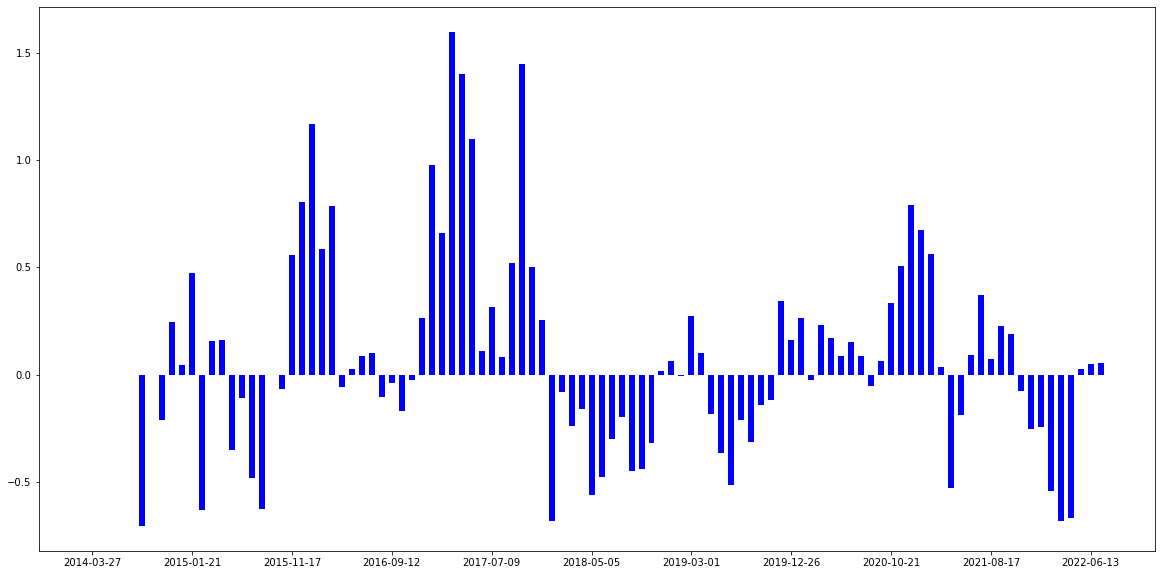

In [159]:
plt.figure(figsize=(20,10))
plt.bar(x_index[:],short_return[:], width=0.6, color='blue')
plt.xticks(np.arange(0, len(long_short), 10))

([<matplotlib.axis.XTick at 0x23c19d30d90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

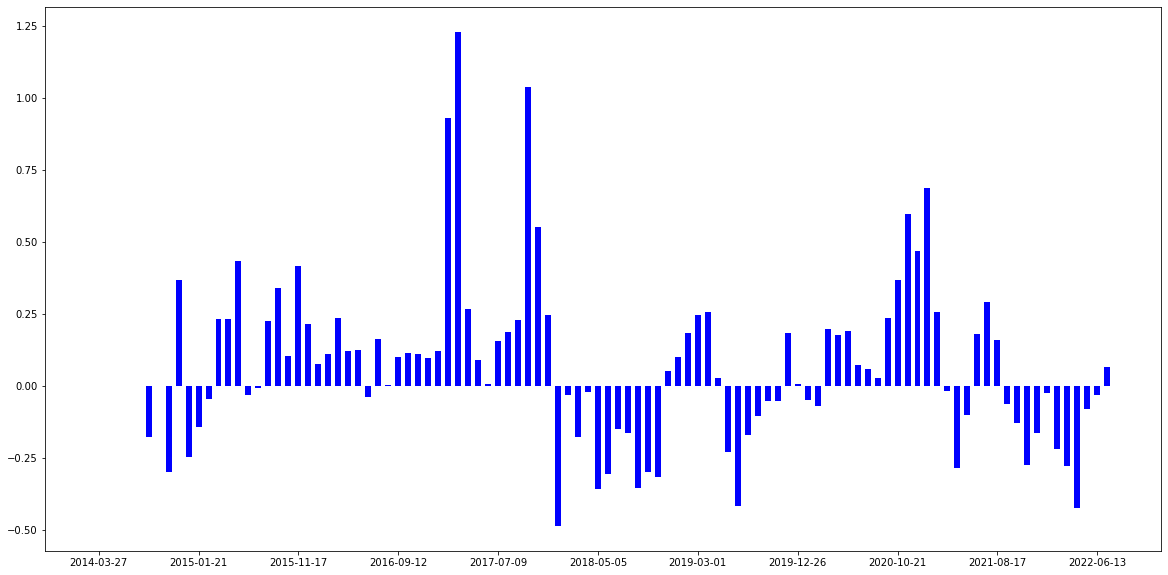

In [158]:
plt.figure(figsize=(20,10))
plt.bar(x_index[:],long_return[:], width=0.6, color='blue')
plt.xticks(np.arange(0, len(long_short), 10))

In [155]:
long_short = np.subtract(long_return, short_return)

In [156]:
x_index = [str(k_dataset[i]['BTC']['Date'].iloc[0])[:10] for i in range(len(short_return))]

([<matplotlib.axis.XTick at 0x23c22599580>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

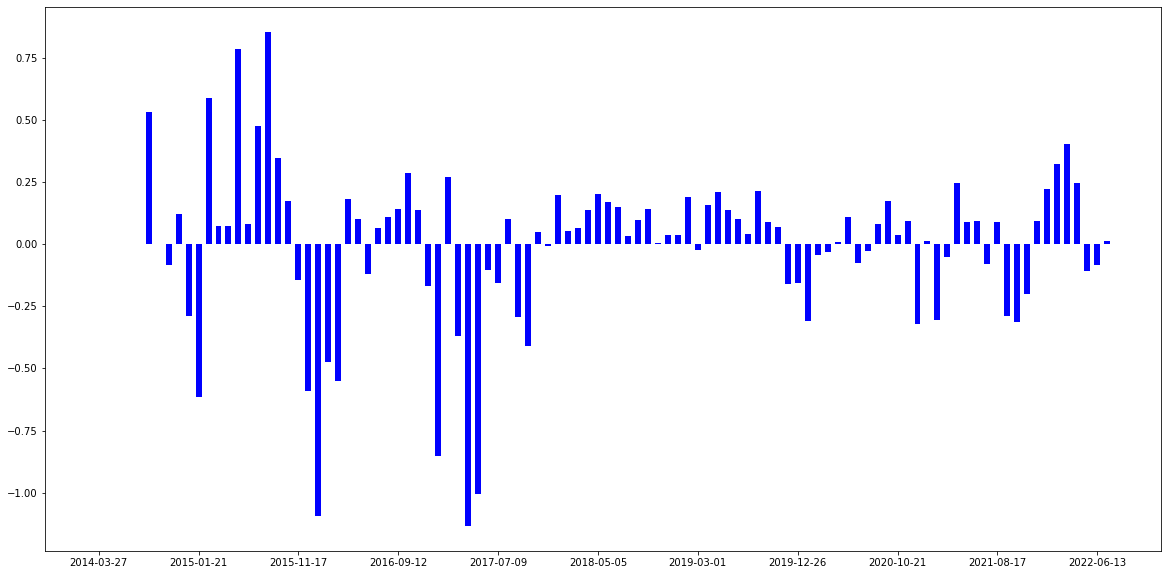

In [157]:
plt.figure(figsize=(20,10))
plt.bar(x_index[:],long_short[:], width=0.6, color='blue')
plt.xticks(np.arange(0, len(long_short), 10))

In [146]:
column_names = ['long_log_return', 'short_log_return', 'long_short_log_return']
return_dataframe = pd.DataFrame(columns=column_names)
for long_log_return, short_log_return, long_short_log_return in zip(long_return[45:], short_return[45:], long_short[45:]):
     return_dataframe = return_dataframe.append(pd.Series([long_log_return, short_log_return, long_short_log_return], index=return_dataframe.columns), ignore_index=True)
    

In [148]:
sum(return_dataframe['long_short_log_return'])

2.256718191202906

# T 統計量

In [168]:
for column in ['long_log_return', 'short_log_return', 'long_short_log_return']:
    mean = np.mean(return_dataframe[column])
    std = np.std(return_dataframe[column], ddof=1)
    t = (mean-0)/(std/np.sqrt(len(return_dataframe[column])))
    print(t)

-0.277241642029301
-1.0933572591937237
1.8741821595723274


In [166]:
np.mean(return_dataframe['long_log_return'])

-0.009169541648664525

In [167]:
return_dataframe

,long_log_return,short_log_return,long_short_log_return
0,0.246693,0.252695,-0.006002
1,-0.485782,-0.681253,0.195471
2,-0.029768,-0.083736,0.053968
3,-0.175045,-0.238379,0.063335
4,-0.021956,-0.160847,0.138892
5,-0.357928,-0.559853,0.201925
6,-0.306679,-0.476548,0.169870
7,-0.149067,-0.298678,0.149611
8,-0.163774,-0.196101,0.032327
9,-0.353144,-0.449982,0.096838


##################################################################################################################

# OLS

data preprocessing

In [391]:
indices = [index for index, value in enumerate(individual_return) if value == 'error']

In [392]:
for index in reversed(indices):
    individual_return.pop(index)
    profolio_std.pop(index)

In [259]:
## import pandas as pd




# 執行迴歸分析


# 儲存結果
#results.append(result.params[1])

# 顯示結果
print(result)

In [250]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     16.77
Date:                Fri, 12 May 2023   Prob (F-statistic):           4.75e-05
Time:                        17:45:43   Log-Likelihood:                -629.59
No. Observations:                 649   AIC:                             1263.
Df Residuals:                     647   BIC:                             1272.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4226      0.059     -7.163      0.000      -0.538      -0.307
x1             2.7130      0.662      4.095      0.000       1.412       4.014
==============================================================================
Omnibus:                       45.700   Durbin-Watson:                   0.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.262
Skew:                           0.092   Prob(JB):                     1.32e-41
Kurtosis:                       5.632   Cond. No.                         26.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [229]:
# 绘制散点图
#plt.scatter(profolio_std[200:], individual_return[200:], alpha=0.5)

# 绘制回归线
plt.plot(model.predict(), c='r')

TypeError: predict() missing 1 required positional argument: 'params'

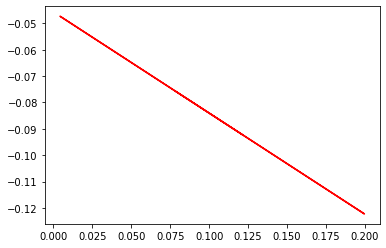

In [235]:
params = result.params # 获取模型参数
plt.plot(profolio_std[200:], model.predict(params=params), c='r')

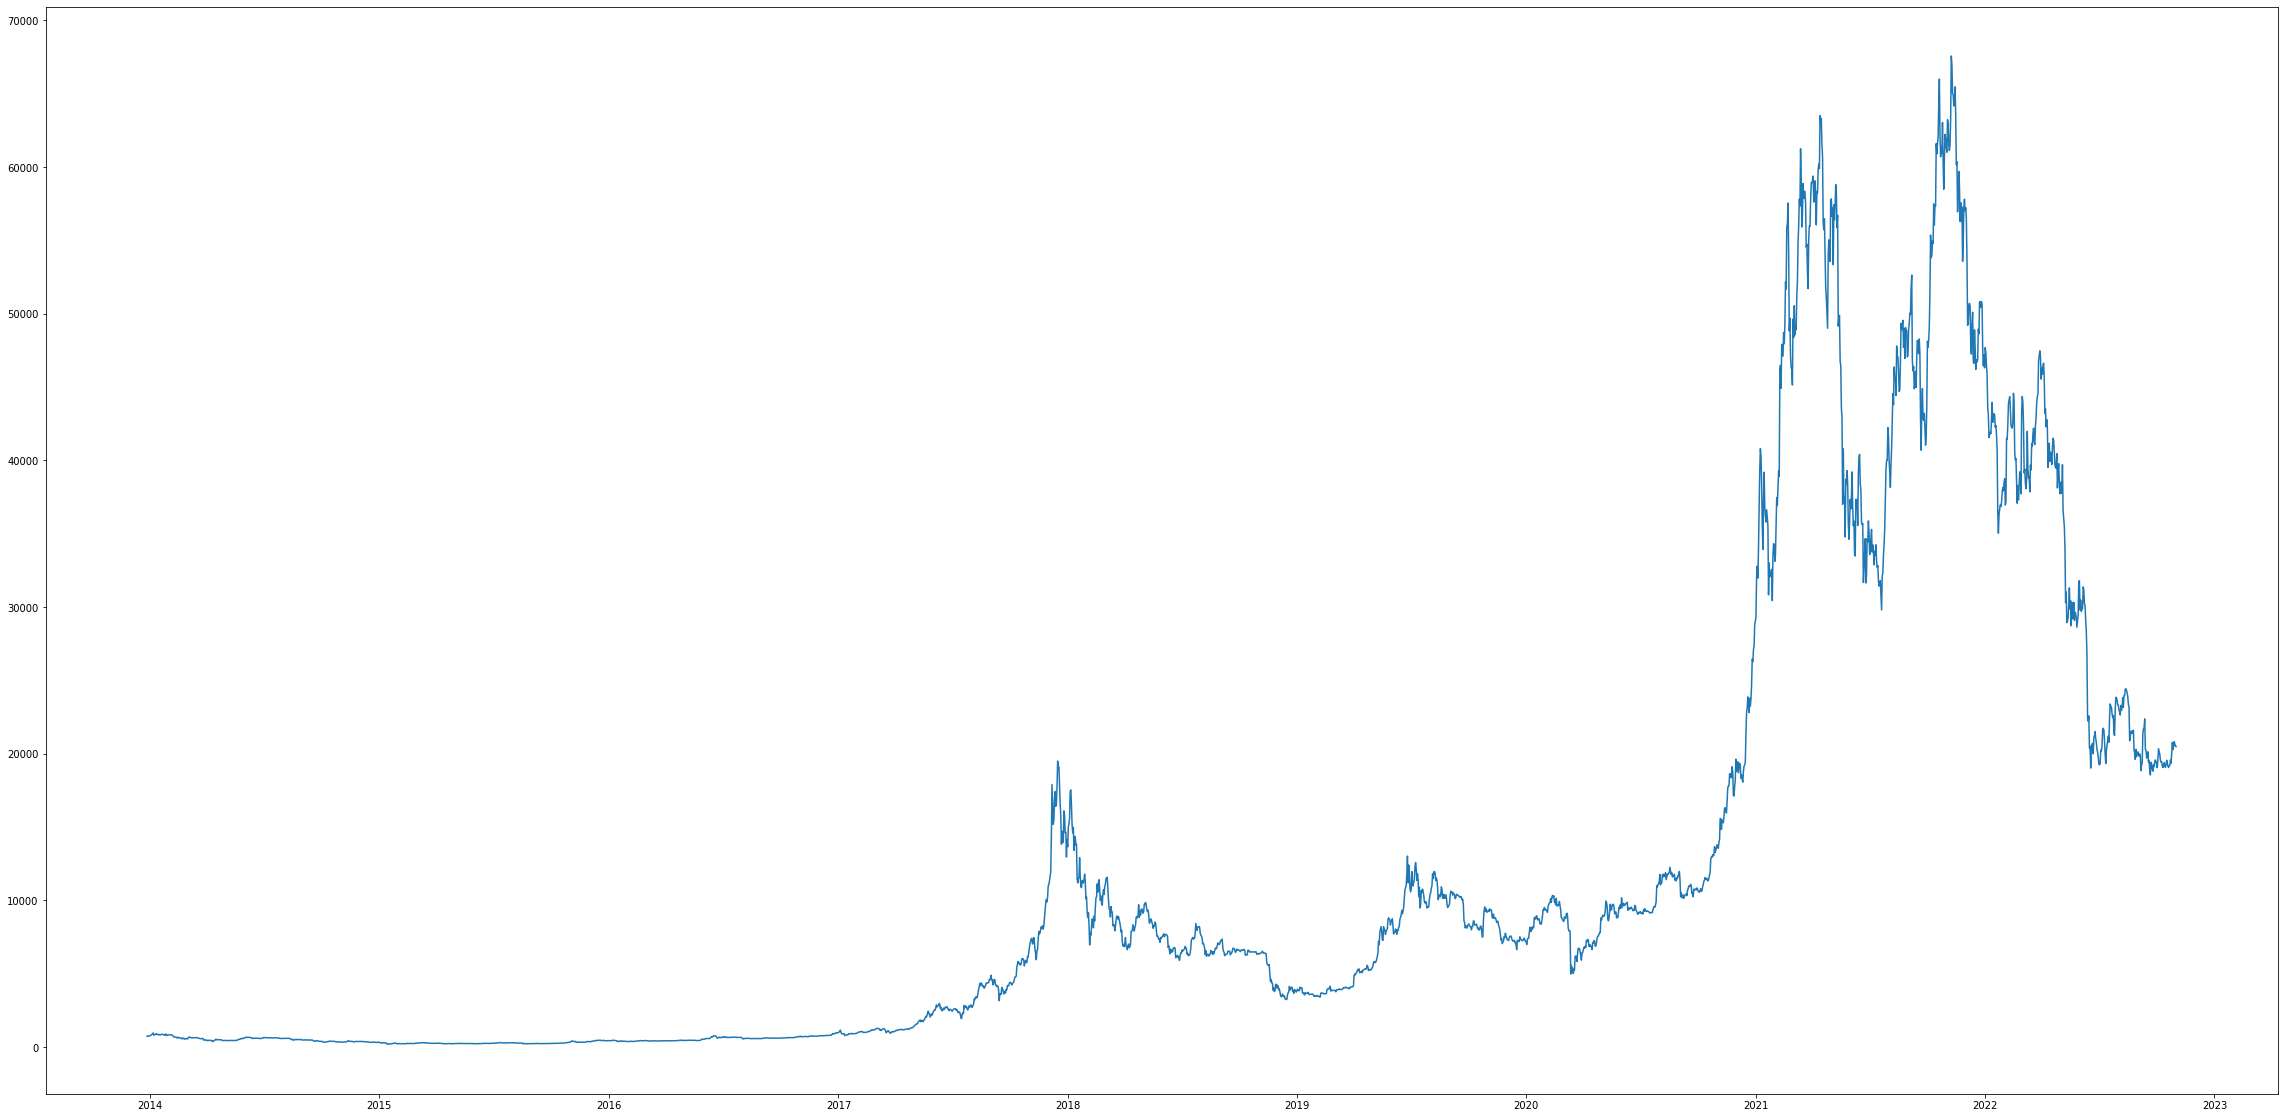

In [267]:
plt.figure(figsize=(40,20))
plt.plot(diff_symbol['BTC']['Date'], diff_symbol['BTC']['Close'])

# test

In [405]:
import numpy as np
import pandas as pd
import requests as rq
from bs4 import BeautifulSoup
import json
import time

In [406]:
def get_top100_crypto(url):
    #url = 'https://coinmarketcap.com'
    response = rq.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    data= soup.find('script',id="__NEXT_DATA__",type="application/json")
    dataset = []
    coins = []
    coin_data=json.loads(data.contents[0])
    listings=json.loads(coin_data["props"]["initialState"])["cryptocurrency"]['listingLatest']['data']
    for i in listings[1:]: 
        coins.append(i[-4])
    return coins


def get_top100_crypto_hist_price(coin_list):
    top_100_hist_price = {}
    for coin in coin_list:
        coin = coin+'USDT'
        print(coin)
        hist_price = hist_crypto_price(coin, '1d')
        hist_price['timestamp'] = pd.to_datetime(hist_price['timestamp'])
        top_100_hist_price.update({coin:hist_price})
        
    for crypto in ['USDCUSDT', 'TUSDUSDT', 'BUSDUSDT', 'USDTUSDT', 'PAXGUSDT']:
        del top_100_hist_price[crypto]
    return top_100_hist_price


def split_hist_price(price_dict, window_size):
    dataset = {}
    
    for crypto, price  in price_dict.items():
        if len(price)>window_size:
            dataset.update({crypto:price.iloc[-window_size:].reset_index(drop=True)})
    return dataset


def calculate_daily_return(df):
    df['daily_return'] = df['close'].pct_change()


def calculate_std(df):
    std_value = df['daily_return'].std()
    return std_value

def hist_crypto_price(tradingpair, period):
    '''

    Parameters
    ----------
    tradingpair : str
        cryptocurency trading pair
    period : str
        the time which create a candlestick
        
    Returns
    -------
    price_data : data
        crypto history price data

    ''' 
    
    # 設置 API endpoint 和參數
    endpoint = 'https://api.binance.com/api/v3/klines'
    params = {
        'symbol': tradingpair,  # 設置要查詢的交易對
        'interval': period,    # 設置時間間隔 (1d = 1 day)
        'limit': 1000        # 設置獲取歷史價格的數量 (最多1000)
    }
    # 請求歷史價格數據
    response = rq.get(endpoint, params=params)
    data = json.loads(response.text)
    
    # 將數據轉換為 pandas DataFrame
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume',
                                     'close_time', 'quote_asset_volume', 'number_of_trades',
                                     'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
                                     'ignore'])
    # 轉換時間戳 (timestamp) 到日期格式
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.astype({'open':float, 'high':float, 'low':float, 'close':float, 'volume':float,
                                     'close_time':float, 'quote_asset_volume':float, 'number_of_trades':float,
                                     'taker_buy_base_asset_volume':float, 'taker_buy_quote_asset_volume':float,
                                     'ignore':float})
    # 列印 DataFrame
    #print(df)
    return df


In [352]:
coins = get_top100_crypto('https://coinmarketcap.com')   
top_100_hist_price = get_top100_crypto_hist_price(coins)
'''
dataset = split_hist_price(top_100_hist_price, window_size=J_VALUE)
# calculate daily return -> SD -> sort(ascending)
for price_data in dataset.values():
    calculate_daily_return(price_data)
# calculate SD
crypto_std = {}
for crypto, price_data in dataset.items():
    crypto_std.update({crypto:calculate_std(price_data.iloc[1:].reset_index(drop=True))})
sorted_dict = sorted(crypto_std.items(), key=lambda x: (x[1], x[0]))
# build profolio
# create order
binance_transaction = Binance_transaction(BINANCE_KEY, BINANCE_SECRET, SYS_MAIL_ADDRESS, APP_PWD, CLINET_MAIL_ADDRESS)    
long_positions = build_long_position(binance_transaction, sorted_dict, 0.2)
short_positions = build_short_position(binance_transaction, sorted_dict, 0.2)
# define hoding period
time.sleep(K_VALUE*86400)
# close position
close_all_position(binance_transaction, long_positions, short_positions)   
'''

BTCUSDT
ETHUSDT
USDTUSDT
BNBUSDT
USDCUSDT
XRPUSDT
ADAUSDT
DOGEUSDT
SOLUSDT
MATICUSDT
DOTUSDT
TRXUSDT
LTCUSDT
BUSDUSDT
SHIBUSDT
AVAXUSDT
DAIUSDT
WBTCUSDT
LINKUSDT
LEOUSDT
ATOMUSDT
UNIUSDT
XMRUSDT
OKBUSDT
ETCUSDT
XLMUSDT
TONUSDT
ICPUSDT
BCHUSDT
TUSDUSDT
FILUSDT
LDOUSDT
HBARUSDT
APTUSDT
CROUSDT
ARBUSDT
NEARUSDT
VETUSDT
QNTUSDT
APEUSDT
ALGOUSDT
USDPUSDT
GRTUSDT
FTMUSDT
EGLDUSDT
EOSUSDT
SANDUSDT
THETAUSDT
AAVEUSDT
RPLUSDT
BITUSDT
STXUSDT
MANAUSDT
XTZUSDT
AXSUSDT
FLOWUSDT
KCSUSDT
CHZUSDT
USDDUSDT
CFXUSDT
IMXUSDT
BSVUSDT
CRVUSDT
RNDRUSDT
NEOUSDT
PEPEUSDT
MKRUSDT
KLAYUSDT
SUIUSDT
GUSDUSDT
BTTUSDT
OPUSDT
PAXGUSDT
CSPRUSDT
ZECUSDT
GMXUSDT
SNXUSDT
LUNCUSDT
XECUSDT
MINAUSDT
MIOTAUSDT
GTUSDT
KAVAUSDT
INJUSDT
XDCUSDT
FXSUSDT
TWTUSDT
DASHUSDT
HTUSDT
FLRUSDT
WOOUSDT
RUNEUSDT
NEXOUSDT
LRCUSDT
CAKEUSDT
ZILUSDT
CVXUSDT
FLOKIUSDT
1INCHUSDT
ENJUSDT


'\ndataset = split_hist_price(top_100_hist_price, window_size=J_VALUE)\n# calculate daily return -> SD -> sort(ascending)\nfor price_data in dataset.values():\n    calculate_daily_return(price_data)\n# calculate SD\ncrypto_std = {}\nfor crypto, price_data in dataset.items():\n    crypto_std.update({crypto:calculate_std(price_data.iloc[1:].reset_index(drop=True))})\nsorted_dict = sorted(crypto_std.items(), key=lambda x: (x[1], x[0]))\n# build profolio\n# create order\nbinance_transaction = Binance_transaction(BINANCE_KEY, BINANCE_SECRET, SYS_MAIL_ADDRESS, APP_PWD, CLINET_MAIL_ADDRESS)    \nlong_positions = build_long_position(binance_transaction, sorted_dict, 0.2)\nshort_positions = build_short_position(binance_transaction, sorted_dict, 0.2)\n# define hoding period\ntime.sleep(K_VALUE*86400)\n# close position\nclose_all_position(binance_transaction, long_positions, short_positions)   \n'

In [409]:
def calculate_daily_return(price_dict):
    for price_data in price_dict.values():
        print(price_data['close'].pct_change())
        price_data['return'] = np.log(price_data['close']).diff()      

In [410]:
calculate_daily_return(top_100_hist_price)

0           NaN
1     -0.027369
2     -0.015941
3      0.008419
4     -0.027183
         ...   
995   -0.001464
996   -0.001068
997   -0.022832
998   -0.006437
999   -0.001064
Name: close, Length: 1000, dtype: float64
0           NaN
1     -0.020748
2     -0.034341
3      0.020812
4     -0.067245
         ...   
995   -0.000563
996   -0.003076
997   -0.025282
998    0.007329
999   -0.003131
Name: close, Length: 1000, dtype: float64
0           NaN
1     -0.022370
2     -0.025877
3      0.031851
4     -0.042878
         ...   
995   -0.005417
996    0.007049
997   -0.021635
998    0.003252
999    0.004538
Name: close, Length: 1000, dtype: float64
0           NaN
1     -0.040838
2     -0.042180
3      0.008387
4     -0.043980
         ...   
995    0.001401
996    0.003264
997   -0.022310
998    0.023295
999   -0.007898
Name: close, Length: 1000, dtype: float64
0           NaN
1     -0.024788
2     -0.052954
3      0.034475
4     -0.081861
         ...   
995   -0.005475
996    0.016515


In [411]:
def split_time_seq(df_dict, j_window_size = 90, k_window_size = 90):
    j_dataset = []
    k_dataset = []
    price_data = list(df_dict.values())
    symbol = list(df_dict.keys())
        
    for i in range(0, len(df_dict['BTCUSDT']), 30):
        try:
            j_start_date = df_dict['BTCUSDT']['timestamp'][i]
            j_end_date = df_dict['BTCUSDT']['timestamp'][i+j_window_size]
            k_start_date = df_dict['BTCUSDT']['timestamp'][i+j_window_size]
            k_end_date = df_dict['BTCUSDT']['timestamp'][i+k_window_size+j_window_size]

            j_window_data = {}
            k_window_data = {}
            print(j_start_date)
            print(j_end_date)
    
        except:
            break
            
            
        for j in range(len(price_data)):
            try:
                j_start_index = price_data[j].index[price_data[j]['timestamp'] == j_start_date].to_list()[0]
                j_end_index = price_data[j].index[price_data[j]['timestamp'] == j_end_date].to_list()[0]
                j_window_data[symbol[j]] = price_data[j].iloc[j_start_index:j_end_index].reset_index(drop=True) 

                k_start_index = price_data[j].index[price_data[j]['timestamp'] == k_start_date].to_list()[0]
                k_end_index = price_data[j].index[price_data[j]['timestamp'] == k_end_date].to_list()[0]
                k_window_data[symbol[j]] = price_data[j].iloc[k_start_index:k_end_index].reset_index(drop=True)                    
            
            except:
                pass
            
        j_dataset.append(j_window_data)
        k_dataset.append(k_window_data)    

    return j_dataset, k_dataset

In [412]:
j_data, k_data = split_time_seq(top_100_hist_price, j_window_size = 90, k_window_size = 90)

2020-08-17 00:00:00
2020-11-15 00:00:00
2020-09-16 00:00:00
2020-12-15 00:00:00
2020-10-16 00:00:00
2021-01-14 00:00:00
2020-11-15 00:00:00
2021-02-13 00:00:00
2020-12-15 00:00:00
2021-03-15 00:00:00
2021-01-14 00:00:00
2021-04-14 00:00:00
2021-02-13 00:00:00
2021-05-14 00:00:00
2021-03-15 00:00:00
2021-06-13 00:00:00
2021-04-14 00:00:00
2021-07-13 00:00:00
2021-05-14 00:00:00
2021-08-12 00:00:00
2021-06-13 00:00:00
2021-09-11 00:00:00
2021-07-13 00:00:00
2021-10-11 00:00:00
2021-08-12 00:00:00
2021-11-10 00:00:00
2021-09-11 00:00:00
2021-12-10 00:00:00
2021-10-11 00:00:00
2022-01-09 00:00:00
2021-11-10 00:00:00
2022-02-08 00:00:00
2021-12-10 00:00:00
2022-03-10 00:00:00
2022-01-09 00:00:00
2022-04-09 00:00:00
2022-02-08 00:00:00
2022-05-09 00:00:00
2022-03-10 00:00:00
2022-06-08 00:00:00
2022-04-09 00:00:00
2022-07-08 00:00:00
2022-05-09 00:00:00
2022-08-07 00:00:00
2022-06-08 00:00:00
2022-09-06 00:00:00
2022-07-08 00:00:00
2022-10-06 00:00:00
2022-08-07 00:00:00
2022-11-05 00:00:00


In [502]:
long_position,  short_position, profolio_std = get_profolio(j_data)

{'DOGEUSDT': 0.02214132579776323, 'BTCUSDT': 0.02611411466005437, 'XRPUSDT': 0.02892730053927638, 'ETCUSDT': 0.030549976919579596, 'HBARUSDT': 0.036513448881255, 'EOSUSDT': 0.03794228007328397, 'XLMUSDT': 0.03810287006393249, 'BCHUSDT': 0.03863837751678399, 'BTTUSDT': 0.038759137885415296, 'ETHUSDT': 0.04205336266992331, 'LTCUSDT': 0.04269935579725272, 'XMRUSDT': 0.04372310485562632, 'DASHUSDT': 0.04393127742376361, 'MKRUSDT': 0.046337791892385224, 'XTZUSDT': 0.04720718719723415, 'BNBUSDT': 0.04880982570697961, 'ENJUSDT': 0.04888582992705889, 'ADAUSDT': 0.049371844884654036, 'TRXUSDT': 0.049519229122792045, 'CHZUSDT': 0.05312382717780445, 'NEOUSDT': 0.0553025092882565, 'ZECUSDT': 0.05688156897064716, 'MATICUSDT': 0.057112770485323955, 'MANAUSDT': 0.0599696060236431, 'THETAUSDT': 0.06127399686935626, 'VETUSDT': 0.06197523944340387, 'ZILUSDT': 0.06281198432012491, 'ALGOUSDT': 0.06589534622860366, 'LINKUSDT': 0.0693068477872642, 'ATOMUSDT': 0.07247120661599585, 'STXUSDT': 0.07636253382145

In [425]:
long_position

[['DOGEUSDT',
  'BTCUSDT',
  'XRPUSDT',
  'ETCUSDT',
  'HBARUSDT',
  'EOSUSDT',
  'XLMUSDT'],
 ['BTCUSDT',
  'BNBUSDT',
  'XMRUSDT',
  'DOGEUSDT',
  'ETHUSDT',
  'EOSUSDT',
  'TRXUSDT',
  'ETCUSDT'],
 ['BTCUSDT',
  'BNBUSDT',
  'TRXUSDT',
  'XMRUSDT',
  'ETHUSDT',
  'XTZUSDT',
  'BTTUSDT',
  'ATOMUSDT',
  'NEOUSDT'],
 ['BTCUSDT',
  'XMRUSDT',
  'TRXUSDT',
  'ETCUSDT',
  'ETHUSDT',
  'BNBUSDT',
  'STXUSDT',
  'NEOUSDT',
  'EOSUSDT'],
 ['BTCUSDT',
  'TRXUSDT',
  'ETHUSDT',
  'XMRUSDT',
  'LTCUSDT',
  'STXUSDT',
  'XTZUSDT',
  'EOSUSDT',
  'NEOUSDT'],
 ['BTCUSDT',
  'XMRUSDT',
  'ETHUSDT',
  'LTCUSDT',
  'BCHUSDT',
  'NEOUSDT',
  'XLMUSDT',
  'ZECUSDT',
  'EOSUSDT'],
 ['BTCUSDT',
  'ETHUSDT',
  'DOTUSDT',
  'XMRUSDT',
  'SNXUSDT',
  'LTCUSDT',
  'AAVEUSDT',
  'EGLDUSDT',
  'LINKUSDT',
  'ALGOUSDT'],
 ['BTCUSDT',
  'ETHUSDT',
  'ADAUSDT',
  'EGLDUSDT',
  'ALGOUSDT',
  'XLMUSDT',
  'LTCUSDT',
  'BNBUSDT',
  'NEARUSDT',
  'UNIUSDT'],
 ['BTCUSDT',
  'ETHUSDT',
  'ADAUSDT',
  'XLMUSDT',
  'EGL

In [510]:
def get_return(k_data, long_position, short_position):
    long_return = []
    short_return = []
    for price_data, long, short in zip(k_data, long_position, short_position):

        long_profit = 0
        short_profit = 0
        if len(long) ==0:
            
            long_return.append(long_profit)
            short_return.append(short_profit)
            continue
        else:
            for long_symbol in long:
                try:
                    print('symbol:', long_symbol)
                    print('long:', price_data[long_symbol]['close'].iloc[0])
                    print('long-1:', price_data[long_symbol]['close'].iloc[-1])
                    #long_profit+=((price_data[long_symbol]['close'].iloc[-1]-price_data[long_symbol]['close'].iloc[0])/price_data[long_symbol]['close'].iloc[0])
                    long_profit+=exp.math(sum(price_data[long_symbol]['return']))-1
                except:
                    pass
            for short_symbol in short:
                try:
                    print('s_symbol:', short_symbol)
                    print('long:', price_data[short_symbol]['close'].iloc[0])
                    print('short-1:', price_data[short_symbol]['close'].iloc[-1])
                    short_profit+=math.exp(sum(price_data[short_symbol]['return']))-1
                    #short_profit+=((price_data[short_symbol]['close'].iloc[-1]-price_data[short_symbol]['close'].iloc[0])/price_data[short_symbol]['close'].iloc[0])
                except:
                    pass
            print(long_profit/(len(long)+len(short)))
            print(short_profit/(len(long)+len(short)))
            long_return.append(long_profit/(len(long)+len(short)))
            short_return.append(short_profit/(len(long)+len(short)))
        print('------------')
    return long_return, short_return

In [438]:
long_position

[['DOGEUSDT',
  'BTCUSDT',
  'XRPUSDT',
  'ETCUSDT',
  'HBARUSDT',
  'EOSUSDT',
  'XLMUSDT'],
 ['BTCUSDT',
  'BNBUSDT',
  'XMRUSDT',
  'DOGEUSDT',
  'ETHUSDT',
  'EOSUSDT',
  'TRXUSDT',
  'ETCUSDT'],
 ['BTCUSDT',
  'BNBUSDT',
  'TRXUSDT',
  'XMRUSDT',
  'ETHUSDT',
  'XTZUSDT',
  'BTTUSDT',
  'ATOMUSDT',
  'NEOUSDT'],
 ['BTCUSDT',
  'XMRUSDT',
  'TRXUSDT',
  'ETCUSDT',
  'ETHUSDT',
  'BNBUSDT',
  'STXUSDT',
  'NEOUSDT',
  'EOSUSDT'],
 ['BTCUSDT',
  'TRXUSDT',
  'ETHUSDT',
  'XMRUSDT',
  'LTCUSDT',
  'STXUSDT',
  'XTZUSDT',
  'EOSUSDT',
  'NEOUSDT'],
 ['BTCUSDT',
  'XMRUSDT',
  'ETHUSDT',
  'LTCUSDT',
  'BCHUSDT',
  'NEOUSDT',
  'XLMUSDT',
  'ZECUSDT',
  'EOSUSDT'],
 ['BTCUSDT',
  'ETHUSDT',
  'DOTUSDT',
  'XMRUSDT',
  'SNXUSDT',
  'LTCUSDT',
  'AAVEUSDT',
  'EGLDUSDT',
  'LINKUSDT',
  'ALGOUSDT'],
 ['BTCUSDT',
  'ETHUSDT',
  'ADAUSDT',
  'EGLDUSDT',
  'ALGOUSDT',
  'XLMUSDT',
  'LTCUSDT',
  'BNBUSDT',
  'NEARUSDT',
  'UNIUSDT'],
 ['BTCUSDT',
  'ETHUSDT',
  'ADAUSDT',
  'XLMUSDT',
  'EGL

In [511]:
long_return, short_return = get_return(k_data, long_position, short_position)

symbol: DOGEUSDT
long: 0.0027718
long-1: 0.0697675
symbol: BTCUSDT
long: 15957.0
long-1: 47287.6
symbol: XRPUSDT
long: 0.26954
long-1: 0.609
symbol: ETCUSDT
long: 5.0241
long-1: 11.9265
symbol: HBARUSDT
long: 0.03142
long-1: 0.1377
symbol: EOSUSDT
long: 2.4961
long-1: 4.7489
symbol: XLMUSDT
long: 0.08009
long-1: 0.52853
s_symbol: LRCUSDT
long: 0.17638
short-1: 0.81809
s_symbol: KAVAUSDT
long: 1.479
short-1: 5.2
s_symbol: SANDUSDT
long: 0.037568
short-1: 0.163993
s_symbol: SNXUSDT
long: 4.125
short-1: 27.132
s_symbol: SOLUSDT
long: 2.0407
short-1: 9.2
s_symbol: FTMUSDT
long: 0.01769
short-1: 0.18452
s_symbol: CRVUSDT
long: 0.78
short-1: 3.387
0.0
2.2575906543952766
------------
symbol: BTCUSDT
long: 19426.43
long-1: 58968.31
symbol: BNBUSDT
long: 29.5053
long-1: 263.238
symbol: XMRUSDT
long: 150.5
long-1: 232.25
symbol: DOGEUSDT
long: 0.0032078
long-1: 0.058221
symbol: ETHUSDT
long: 588.64
long-1: 1848.1
symbol: EOSUSDT
long: 2.8615
long-1: 3.9256
symbol: TRXUSDT
long: 0.02918
long-1: 0

short-1: 1.3702
s_symbol: SANDUSDT
long: 4.8444
short-1: 2.9619
s_symbol: LRCUSDT
long: 2.3005
short-1: 0.7405
s_symbol: CFXUSDT
long: 0.2032
short-1: 0.1256
s_symbol: SHIBUSDT
long: 3.346e-05
short-1: 2.385e-05
s_symbol: MANAUSDT
long: 3.2334
short-1: 2.4944
0.0
-0.12178405047816353
------------
symbol: USDPUSDT
long: 1.0
long-1: 0.9998
symbol: BTCUSDT
long: 41864.62
long-1: 42252.01
symbol: TRXUSDT
long: 0.06611
long-1: 0.06259
symbol: ETCUSDT
long: 29.73
long-1: 40.49
symbol: XRPUSDT
long: 0.753
long-1: 0.7549
symbol: ETHUSDT
long: 3151.97
long-1: 3192.39
symbol: BNBUSDT
long: 438.7
long-1: 421.5
symbol: KLAYUSDT
long: 1.351
long-1: 1.072
symbol: BCHUSDT
long: 376.8
long-1: 323.0
symbol: XECUSDT
long: 9.617e-05
long-1: 0.00010114
symbol: XMRUSDT
long: 191.0
long-1: 217.2
symbol: CAKEUSDT
long: 10.75
long-1: 8.4
s_symbol: ZECUSDT
long: 144.1
short-1: 165.7
s_symbol: STXUSDT
long: 2.064
short-1: 1.238
s_symbol: RUNEUSDT
long: 6.21
short-1: 8.652
s_symbol: ENJUSDT
long: 2.297
short-1: 

short-1: 3.177
s_symbol: EOSUSDT
long: 1.155
short-1: 0.88
s_symbol: INJUSDT
long: 1.836
short-1: 1.305
s_symbol: FILUSDT
long: 5.48
short-1: 3.091
s_symbol: CHZUSDT
long: 0.2143
short-1: 0.1028
s_symbol: FLOWUSDT
long: 1.695
short-1: 0.723
s_symbol: SNXUSDT
long: 2.257
short-1: 1.53
s_symbol: CRVUSDT
long: 0.892
short-1: 0.53
s_symbol: ETCUSDT
long: 27.84
short-1: 15.89
s_symbol: LDOUSDT
long: 1.5
short-1: 1.203
s_symbol: OPUSDT
long: 0.852
short-1: 0.957
0.0
-0.16416327892082755
------------
symbol: TRXUSDT
long: 0.06363
long-1: 0.06383
symbol: BNBUSDT
long: 349.2
long-1: 323.5
symbol: BTCUSDT
long: 21299.37
long-1: 23488.94
symbol: CAKEUSDT
long: 4.828
long-1: 4.145
symbol: TWTUSDT
long: 1.2047
long-1: 1.6434
symbol: VETUSDT
long: 0.02597
long-1: 0.0241
symbol: MANAUSDT
long: 0.712
long-1: 0.7842
symbol: ZILUSDT
long: 0.03245
long-1: 0.02826
symbol: EGLDUSDT
long: 58.14
long-1: 44.99
symbol: STXUSDT
long: 0.337
long-1: 0.283
symbol: XLMUSDT
long: 0.1136
long-1: 0.0918
symbol: XMRUSD

In [505]:
long_short = np.subtract(long_return, short_return)

In [506]:
long_short

array([-2.25759065, -2.81933252, -2.10145115, -0.83257288, -0.28799822,
        0.09218941, -0.30332976, -1.11103022, -0.80464642, -0.88519968,
       -0.46406539, -0.22913643,  0.04800853,  0.12178405,  0.08192612,
        0.19461124,  0.27809355,  0.33148431,  0.17163479,  0.09258623,
        0.06865079,  0.10469417,  0.1331097 ,  0.16416328, -0.10001174,
       -0.42707719, -0.41045967, -0.09792417])

([<matplotlib.axis.XTick at 0x7fec9284ac50>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

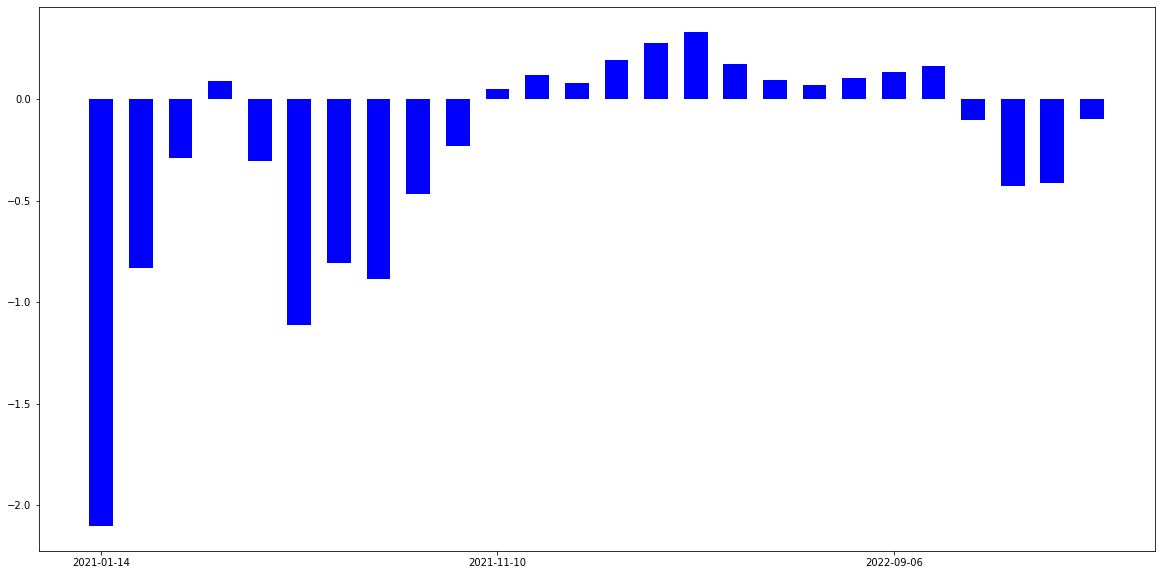

In [507]:
import numpy as np


long_short = np.subtract(long_return, short_return)
x_index = [str(k_data[i]['BTCUSDT']['timestamp'][0])[:10] for i in range(len(short_return))]
plt.figure(figsize=(20,10))
#plt.bar(x_index,short_return, color='yellow')
#plt.bar(x_index, long_return, bottom=short_return)
plt.bar(x_index[2:],long_short[2:], width=0.6, color='blue')
plt.xticks(np.arange(0, len(long_short), 10))

In [443]:
sum(long_short)

-0.048922112582018173